# Thermal Model with Prescribed Flux Neumann Boundary Conditions

This notebook investigates a thermal conduction problem on a unit square domain, where the boundary conditions are given as prescribed fluxes (Neumann BCs) on all sides. The primary goal is to analyze the potential discrepancy between the model's predicted temperatures at specific sensor locations and the actual sensor readings.

To quantify this discrepancy, we perform the following steps:
- Solve the forward problem with only Neumann flux boundary conditions and record the predicted temperatures at sensor points.
- Impose the sensor readings as Dirichlet boundary conditions at those sensor locations and resolve the problem.
- Compute the residual, which is the difference between the model prediction and the enforced sensor values.

This residual is interpreted as a flux: it represents the additional flux required at the sensor locations to reconcile the model with the observed data. By visualizing and analyzing this residual flux, we gain insight into the model's predictive accuracy and the influence of sensor-based corrections.
```

In [39]:
import numpy as np
import dolfinx
from dolfinx import mesh, fem, plot
from mpi4py import MPI
from petsc4py import PETSc
import ufl, time, pyvista as pv
from dolfinx.plot import create_vtk_mesh


## 0. Shared helpers

Define problem parameters, sensor locations, flux functions, and helper routines for locating sensor dofs.

In [40]:

# ------------------------------------------------------------------------------
# 0 .  Shared helpers
# ------------------------------------------------------------------------------
k = 0.01                              # thermal-conductivity
dt, T_end = 0.1, 1.0
num_steps = int(T_end / dt)
sensor_coords = np.array([
    [0.125, 0.50, 0.0],   # L
    [0.875, 0.50, 0.0],   # R
    [0.50, 0.125, 0.0],   # B
    [0.50, 0.875, 0.0]    # T
])
# Add observer sensors in the middle (not used as Dirichlet BCs)
observer_coords = np.array([
    [0.5, 0.5, 0.0],      # Center
    [0.375, 0.5, 0.0],    # Left of center
    [0.625, 0.5, 0.0],    # Right of center
    [0.5, 0.375, 0.0],    # Below center
    [0.5, 0.625, 0.0]     # Above center
])
flux_fun = dict(                     # Neumann flux functions
    top    = lambda t: 1.0*np.exp(-((t-2)/1)**2),
    bottom = lambda t: 0.8*np.sin(np.pi*t/10)**2,
    left   = lambda t: 0.9*np.exp(-((t-6)/1.5)**2),
    right  = lambda t: 0.7*np.cos(np.pi*t/10)**2,
)
flux_fun_perturbed = dict(                     # Neumann flux functions
    top    = lambda t: 1.1*np.exp(-((t-2)/1)**2),
    bottom = lambda t: 1.1*np.sin(np.pi*t/10)**2,
    left   = lambda t: 1.1*np.exp(-((t-6)/1.5)**2),
    right  = lambda t: 1.1*np.cos(np.pi*t/10)**2,
)

def locate_sensor_dofs(V, xyz, tol=1e-8):
    """
    Return dof indices of the mesh vertex closest to each xyz point.
    This is robust even if tol is much smaller than the mesh size.
    """
    mesh_coords = V.mesh.geometry.x
    dofmap = V.dofmap.list.array
    dofs = []
    for pt in xyz:
        # Compute distances from all mesh vertices to the point
        dists = np.linalg.norm(mesh_coords - pt[:mesh_coords.shape[1]], axis=1)
        # Find the closest vertex
        closest_vertex = np.argmin(dists)
        # Find the dof associated with this vertex
        # For CG1, dof index == vertex index
        dofs.append(np.array([closest_vertex], dtype=np.int32))
    return np.array(dofs, dtype=np.int32)


## Problem generator

Define a generator function to set up the PDE problem, apply boundary conditions, and yield the solution and sensor values at each time step.

In [41]:

def make_problem(dirichlet_sequence=None, perturb=False, tag=None):
    """
    Generator that yields (T_step, sensor_values_step) through time for
    one of the three cases.

    Parameters
    ----------
    dirichlet_sequence : ndarray | None
        Shape (num_steps, 4).  If not None, temperatures enforced at the
        four sensor vertices.
    perturb : bool | False
        If given, perturbed generator model.
    tag : str
        Short label, only for printouts.
    """
    # --- build mesh & spaces --------------------------------------------------
    domain = mesh.create_unit_square(MPI.COMM_WORLD, 8, 8)
    V = fem.FunctionSpace(domain, ("CG", 1))

    def measure_sensor(coord, T):
        bb_tree = dolfinx.geometry.BoundingBoxTree(domain, domain.topology.dim)
        cells = []

        # Find cells whose bounding-box collide with the points
        cell_candidates = dolfinx.geometry.compute_collisions(bb_tree, [coord])

        # Choose one of the cells that contains the point
        colliding_cells = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates, [coord])

        # for i, point in enumerate(coord):
        if len(colliding_cells.links(0)) > 0:
            cells.append(colliding_cells.links(0)[0])

        # adding correct units to displacement
        temperature_data = T.eval([coord], cells)

        return temperature_data
    
    # --- facet tags for the four sides (Neumann flux) ------------------------
    fdim = domain.topology.dim - 1
    locate = dolfinx.mesh.locate_entities_boundary
    bndry = {
        1: locate(domain, fdim, lambda x: np.isclose(x[1], 1.0)),  # top
        2: locate(domain, fdim, lambda x: np.isclose(x[1], 0.0)),  # bottom
        3: locate(domain, fdim, lambda x: np.isclose(x[0], 0.0)),  # left
        4: locate(domain, fdim, lambda x: np.isclose(x[0], 1.0)),  # right
    }
    all_facets = np.concatenate(list(bndry.values()))
    values     = np.concatenate([np.full_like(f, i) for i, f in bndry.items()])
    facetsort  = np.argsort(all_facets)
    mt = mesh.meshtags(domain, fdim, all_facets[facetsort], values[facetsort])
    ds = ufl.Measure("ds", domain=domain, subdomain_data=mt)

    # --- point-Dirichlet BC machinery ----------------------------------------
    dirichlet_bcs = []
    if dirichlet_sequence is not None:
        sensor_dofs = locate_sensor_dofs(V, sensor_coords)
        # constant placeholders (one per sensor) that will be updated each step
        constants = [fem.Constant(domain, PETSc.ScalarType(0.0))
                     for _ in range(4)]
        dirichlet_bcs = [fem.dirichletbc(c, np.array([dof]), V)
                         for c, dof in zip(constants, sensor_dofs)]

    # --- variational forms ----------------------------------------------------
    u, v = ufl.TrialFunction(V), ufl.TestFunction(V)
    a = u*v*ufl.dx + dt*k*ufl.dot(ufl.grad(u), ufl.grad(v))*ufl.dx
    A  = fem.petsc.assemble_matrix(fem.form(a), bcs=dirichlet_bcs)
    A.assemble()
    solver = PETSc.KSP().create(domain.comm)
    solver.setOperators(A)
    solver.setType(PETSc.KSP.Type.CG)
    solver.getPC().setType(PETSc.PC.Type.JACOBI)

    # --- time stepping --------------------------------------------------------
    T_n = fem.Function(V)              # previous step
    T   = fem.Function(V)              # current solution
    T_n.name, T.name = "T_n", "T"
    t = 0.0
    if perturb:
        flux_fun_step = flux_fun_perturbed
    else:
        flux_fun_step = flux_fun

    for step in range(num_steps):
        t += dt
        # (re)assemble RHS
        L = T_n*v*ufl.dx \
          + dt*flux_fun_step["top"](t)   *v*ds(1) \
          + dt*flux_fun_step["bottom"](t)*v*ds(2) \
          + dt*flux_fun_step["left"](t)  *v*ds(3) \
          + dt*flux_fun_step["right"](t) *v*ds(4)
        b = fem.petsc.assemble_vector(fem.form(L))
        # update point Dirichlet data if present
        if dirichlet_sequence is not None:
            vals = dirichlet_sequence[step]
            for c, val in zip(constants, vals):
                c.value = PETSc.ScalarType(val)
            fem.petsc.apply_lifting(b, [fem.form(a)], [dirichlet_bcs])
            b.ghostUpdate(addv=PETSc.InsertMode.ADD,
                          mode =PETSc.ScatterMode.REVERSE)
            fem.petsc.set_bc(b, dirichlet_bcs)

        # solve & update
        solver.solve(b, T.vector)
        T.x.scatter_forward()
        T_n.x.array[:] = T.x.array[:]

        # measure sensors
        vals = np.array([measure_sensor(Point,T) for Point in sensor_coords])
        # Also measure observer sensors (not used as Dirichlet BCs)
        observer_vals = np.array([measure_sensor(Point,T) for Point in observer_coords])
        yield T.copy(), vals, observer_vals   # return a *copy* so the generator keeps data


## 1. Run the three experiments

Run three cases: (1) Neumann only, (2) Dirichlet at sensors using results from case 1, and (3) Dirichlet at sensors with added noise.

In [42]:

# ------------------------------------------------------------------------------
# 1 .  Run the four experiments
# ------------------------------------------------------------------------------
case1_T, case1_s, case1_obs = [], [], []
for T, s, obs in make_problem(tag="base"):
    case1_T.append(T)
    case1_s.append(s)
    case1_obs.append(obs)
case1_T, case1_s, case1_obs = np.array(case1_T), np.array(case1_s), np.array(case1_obs)


Run the second experiment: Dirichlet at sensors using results from case 1.

In [43]:

case2_T, case2_s, case2_obs = [], [], []
for T, s, obs in make_problem(dirichlet_sequence=case1_s, tag="sensor-Dirichlet"):
    case2_T.append(T)
    case2_s.append(s)
    case2_obs.append(obs)


  c.value = PETSc.ScalarType(val)



Run the third experiment: Dirichlet at sensors with added noise.

In [44]:

case3_T, case3_s, case3_obs = [], [], []
for T, s, obs in make_problem(dirichlet_sequence=case1_s, perturb=True,
                         tag="perturbed"):
    case3_T.append(T)
    case3_s.append(s)
    case3_obs.append(obs)


  c.value = PETSc.ScalarType(val)



In [45]:

# Fourth case: perturbed flux, no Dirichlet BCs
case4_T, case4_s, case4_obs = [], [], []
for T, s, obs in make_problem(perturb=True, tag="perturbed-no-Dirichlet"):
    case4_T.append(T)
    case4_s.append(s)
    case4_obs.append(obs)
case4_T, case4_s, case4_obs = np.array(case4_T), np.array(case4_s), np.array(case4_obs)


## 2. Post-process: project flux

Project the flux vector field $-k \nabla T$ for the final step of each case.

In [46]:

# ------------------------------------------------------------------------------
# 2 .  Post-process: project flux = −k ∇T (final step of each case)
# ------------------------------------------------------------------------------
def project_flux(T_final):
    domain = T_final.function_space.mesh
    W  = fem.VectorFunctionSpace(domain, ("CG", 1))
    w  = ufl.TestFunction(W)
    tau = ufl.TrialFunction(W)

    # Define the projection variational problem
    flux_expr = -k * ufl.grad(T_final)
    a_p = ufl.inner(tau, w) * ufl.dx
    L_p = ufl.inner(flux_expr, w) * ufl.dx

    # Assemble matrix and RHS
    A_p = fem.petsc.assemble_matrix(fem.form(a_p))
    A_p.assemble()
    b_p = fem.petsc.assemble_vector(fem.form(L_p))
    
    # Create flux function and PETSc KSP solver
    flux = fem.Function(W)
    solver = PETSc.KSP().create(domain.comm)
    solver.setOperators(A_p)
    solver.setType(PETSc.KSP.Type.CG)
    solver.getPC().setType(PETSc.PC.Type.JACOBI)

    solver.solve(b_p, flux.vector)
    flux.x.scatter_forward()
    return flux


flux1 = project_flux(case1_T[-1])
flux2 = project_flux(case2_T[-1])
flux3 = project_flux(case3_T[-1])
flux4 = project_flux(case4_T[-1])


## 2.5. Visualize temperature distributions

Visualize the final temperature fields for all three cases using PyVista, including sensor locations.

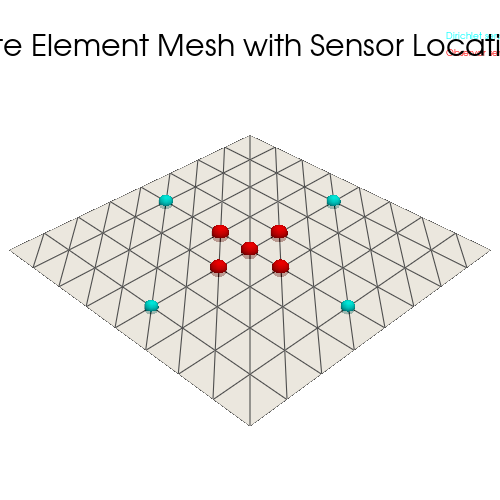

In [47]:
# ------------------------------------------------------------------------------
# 2.6 .  Plot the mesh using PyVista
# ------------------------------------------------------------------------------
pv.set_jupyter_backend("static")  # For inline Jupyter display

if MPI.COMM_WORLD.rank == 0:
    # Use the mesh from the last computed temperature field (case1_T[-1])
    domain = case1_T[-1].function_space.mesh
    topo, cell_types, geometry = create_vtk_mesh(domain, domain.topology.dim)
    mesh_grid = pv.UnstructuredGrid(topo, cell_types, geometry)
    
    plotter = pv.Plotter(window_size=[500, 500])
    plotter.add_mesh(mesh_grid, show_edges=True, color="white", opacity=0.7)
    plotter.add_points(sensor_coords, color="cyan", point_size=15, render_points_as_spheres=True, label="Dirichlet sensors")
    plotter.add_points(observer_coords, color="red", point_size=18, render_points_as_spheres=True, label="Observer sensors")
    plotter.add_legend([("Dirichlet sensors", "c"), ("Observer sensors", "r")], bcolor="w", border=True, size=(0.18, 0.08))
    plotter.add_title("Finite Element Mesh with Sensor Locations", font_size=12)
    # plotter.camera.zoom(1.3)
    plotter.show()

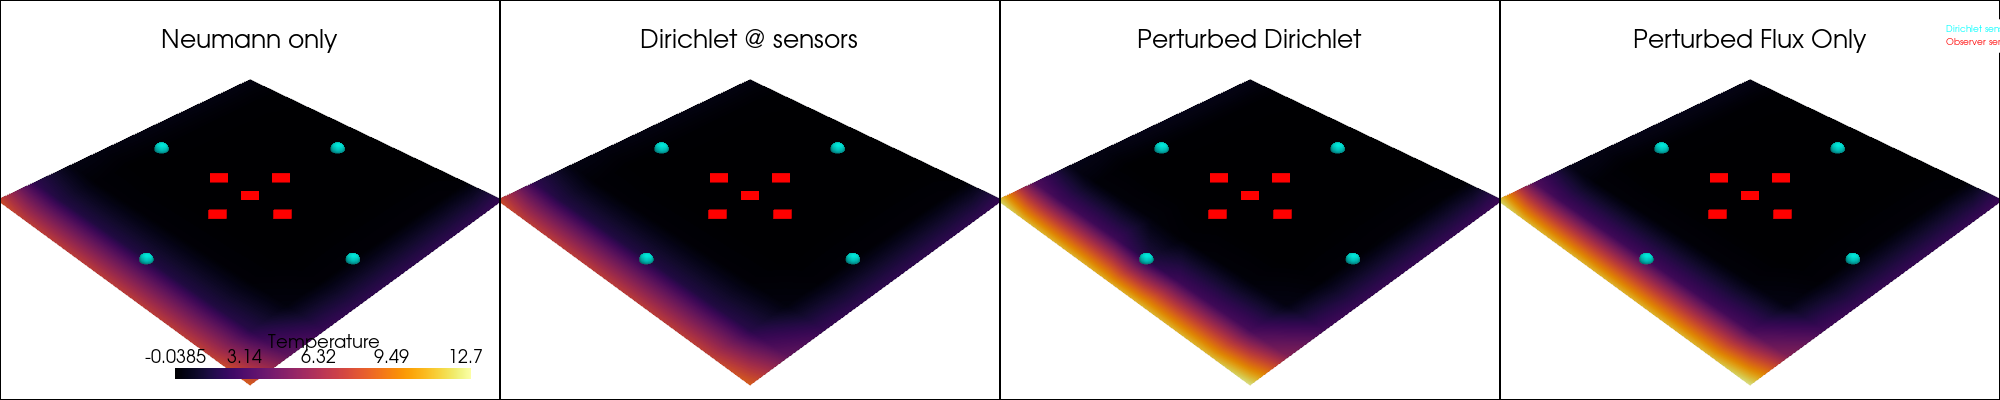

In [48]:
# ------------------------------------------------------------------------------
# 2.5 .  Visualize temperature distributions of the three cases with PyVista
# ------------------------------------------------------------------------------
pv.set_jupyter_backend("static")  # For inline Jupyter display

if MPI.COMM_WORLD.rank == 0:
    def vtk_from_temp(temperature):
        domain = temperature.function_space.mesh
        topo, cell_types, geometry = create_vtk_mesh(domain, domain.topology.dim)
        grid = pv.UnstructuredGrid(topo, cell_types, geometry)
        grid.point_data["temperature"] = temperature.x.array
        return grid

    # Create temperature grids
    temp_grids = [vtk_from_temp(case1_T[-1]), 
                  vtk_from_temp(case2_T[-1]), 
                  vtk_from_temp(case3_T[-1]),
                  vtk_from_temp(case4_T[-1])]
    
    # Visualization
    plotter = pv.Plotter(shape=(1, 4), window_size=[2000, 400])
    
    titles = ["Neumann only", "Dirichlet @ sensors", "Perturbed Dirichlet", "Perturbed Flux Only"]
    
    for i, (grid, title) in enumerate(zip(temp_grids, titles)):
        plotter.subplot(0, i)
        plotter.add_mesh(grid, cmap="inferno", scalar_bar_args={"title": "Temperature"})
        
        # Add Dirichlet sensor points (cyan circles)
        points = pv.PolyData(sensor_coords)
        plotter.add_mesh(points, color="cyan", point_size=15, render_points_as_spheres=True, label="Dirichlet sensors")
        # Add observer sensor points (red squares)
        observer_points = pv.PolyData(observer_coords)
        plotter.add_mesh(observer_points, color="red", point_size=18, render_points_as_spheres=False, style='points', label="Observer sensors")
        
        plotter.add_title(title, font_size=10)
        plotter.camera.zoom(1.3)
    
    # Add legend to the last subplot
    plotter.subplot(0, 3)
    plotter.add_legend([("Dirichlet sensors", "c"), ("Observer sensors", "r")], bcolor="w", border=True, size=(0.18, 0.08))
    plotter.link_views()
    plotter.show()

## 2.7. Plot temperature differences

Visualize the absolute temperature differences between each pair of cases.

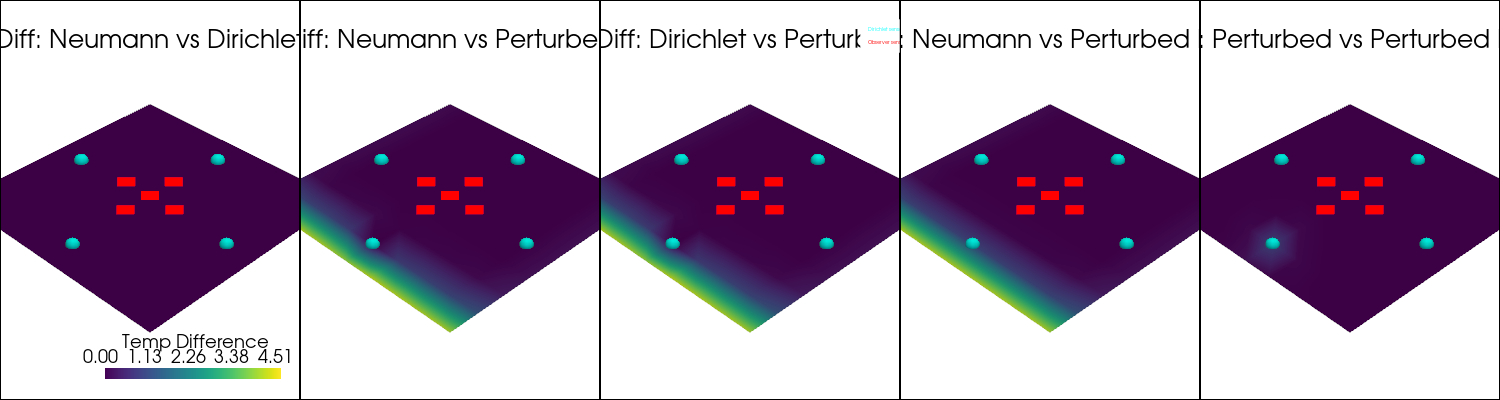

In [54]:
# ------------------------------------------------------------------------------
# 2.7 .  Plot temperature differences between cases
# ------------------------------------------------------------------------------
pv.set_jupyter_backend("static")  # For inline Jupyter display

if MPI.COMM_WORLD.rank == 0:
    def vtk_from_temp_diff(temp1, temp2):
        domain = temp1.function_space.mesh
        topo, cell_types, geometry = create_vtk_mesh(domain, domain.topology.dim)
        grid = pv.UnstructuredGrid(topo, cell_types, geometry)
        
        # Calculate temperature difference
        diff = np.abs(temp1.x.array - temp2.x.array)
        grid.point_data["temp_diff"] = diff
        return grid

    # Create temperature difference grids
    diff_grids = [
        vtk_from_temp_diff(case1_T[-1], case2_T[-1]),  # Case 1 vs Case 2
        vtk_from_temp_diff(case1_T[-1], case3_T[-1]),  # Case 1 vs Case 3
        vtk_from_temp_diff(case2_T[-1], case3_T[-1]),   # Case 2 vs Case 3
        vtk_from_temp_diff(case1_T[-1], case4_T[-1]),  # Case 1 vs Case 4
        vtk_from_temp_diff(case3_T[-1], case4_T[-1])  # Case 2 vs Case 4
    ]
    
    # Visualization
    plotter = pv.Plotter(shape=(1, 5), window_size=[1500, 400])
    
    diff_titles = [
        "Diff: Neumann vs Dirichlet",
        "Diff: Neumann vs Perturbed",
        "Diff: Dirichlet vs Perturbed",
        "Diff: Neumann vs Perturbed Flux",
        "Diff: Perturbed vs Perturbed Flux"
    ]
    
    for i, (grid, title) in enumerate(zip(diff_grids, diff_titles)):
        plotter.subplot(0, i)
        plotter.add_mesh(grid, cmap="viridis", scalar_bar_args={"title": "Temp Difference"})
        # Set consistent color scale for better comparison
        scalar_range = [0, max([grid.get_data_range("temp_diff")[1] for grid in diff_grids])]
        plotter.add_mesh(grid, cmap="viridis", scalar_bar_args={"title": "Temp Difference"}, 
                        clim=scalar_range)
        # Add Dirichlet sensor points (cyan circles)
        points = pv.PolyData(sensor_coords)
        plotter.add_mesh(points, color="cyan", point_size=15, render_points_as_spheres=True, label="Dirichlet sensors")
        # Add observer sensor points (red squares)
        observer_points = pv.PolyData(observer_coords)
        plotter.add_mesh(observer_points, color="red", point_size=18, render_points_as_spheres=False, style='points', label="Observer sensors")
        
        plotter.add_title(title, font_size=10)
        plotter.camera.zoom(1.3)
    
    # Add legend to the last subplot
    plotter.subplot(0, 2)
    plotter.add_legend([("Dirichlet sensors", "c"), ("Observer sensors", "r")], bcolor="w", border=True, size=(0.18, 0.08))
    plotter.link_views()
    plotter.show()

## 3. Visualize flux vector fields

Visualize the projected flux vector fields for the three cases using glyphs.

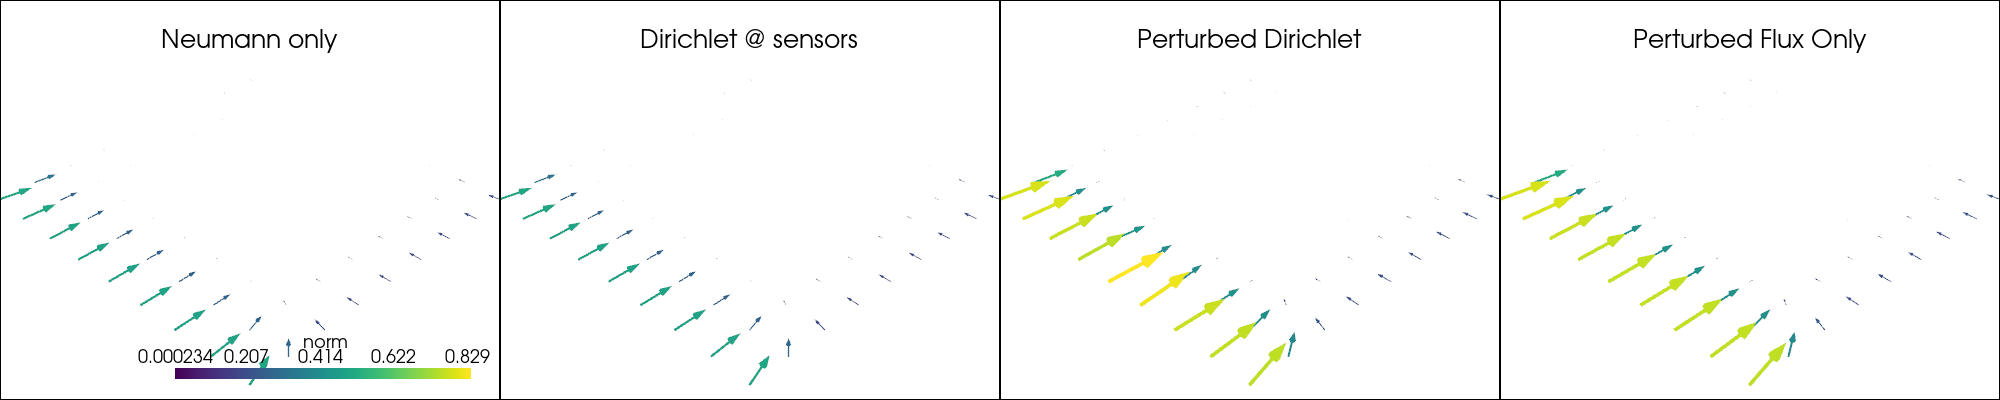

In [ ]:
# ------------------------------------------------------------------------------
# 3 .  Visualize flux vector fields
# ------------------------------------------------------------------------------
# Create PyVista grids for the flux vector fields of the three cases and plot them
pv.set_jupyter_backend("static")
if MPI.COMM_WORLD.rank == 0:
    def vtk_from_flux(flux):
        domain = flux.function_space.mesh
        topo, cell_types, geometry = create_vtk_mesh(domain, domain.topology.dim)
        grid = pv.UnstructuredGrid(topo, cell_types, geometry)
        pts = grid.points.shape[0]
        flux_vec = flux.x.array.reshape((pts, 2))
        # Pad to 3D for PyVista glyphs
        flux_vec_3d = np.pad(flux_vec, ((0, 0), (0, 1)), mode='constant')
        grid.point_data["flux"] = flux_vec_3d
        grid.point_data["norm"] = np.linalg.norm(flux_vec, axis=1)
        return grid

    flux_grids = [vtk_from_flux(flux1), vtk_from_flux(flux2), vtk_from_flux(flux3), vtk_from_flux(flux4)]

    plotter = pv.Plotter(shape=(1, 4), window_size=[2000, 400])
    for i, (g, title) in enumerate(zip(flux_grids, titles)):
        plotter.subplot(0, i)
        arrows = g.glyph(scale="norm", orient="flux", factor=0.2)
        plotter.add_mesh(arrows, lighting=False)
        plotter.add_title(title, font_size=10)
        plotter.camera.zoom(1.3)
    plotter.link_views()
    plotter.show()

## 4. Visualize flux differences

Visualize the differences between the flux vector fields for each pair of cases.

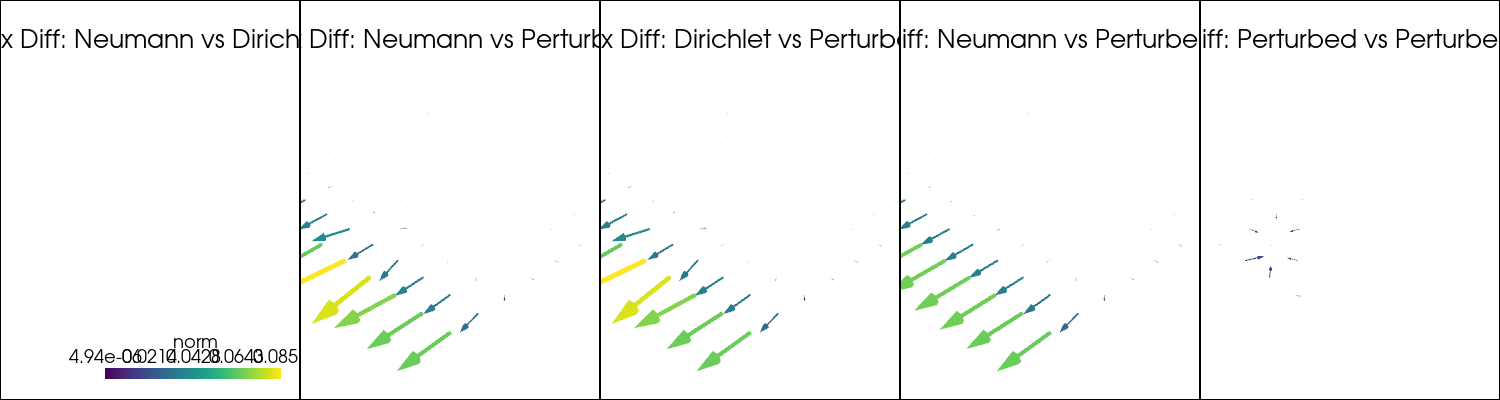

In [56]:
# ------------------------------------------------------------------------------
# 4 .  Visualize flux differences
# ------------------------------------------------------------------------------
# Visualize the difference between the flux vector fields for the three cases with larger glyphs
if MPI.COMM_WORLD.rank == 0:
    flux_diff_grids = []
    flux_diff_titles = [
        "Flux Diff: Neumann vs Dirichlet",
        "Flux Diff: Neumann vs Perturbed",
        "Flux Diff: Dirichlet vs Perturbed",
        "Flux Diff: Neumann vs Perturbed Flux",
        "Flux Diff: Perturbed vs Perturbed Flux"
    ]
    # Compute differences and build grids
    for f1, f2 in [(flux1, flux2), (flux1, flux3), (flux2, flux3), (flux1, flux4), (flux3, flux4)]:
        domain = f1.function_space.mesh
        topo, cell_types, geometry = create_vtk_mesh(domain, domain.topology.dim)
        grid = pv.UnstructuredGrid(topo, cell_types, geometry)
        pts = grid.points.shape[0]
        diff = f1.x.array.reshape((pts, 2)) - f2.x.array.reshape((pts, 2))
        grid.point_data["flux_diff"] = diff
        grid.point_data["norm"] = np.linalg.norm(diff, axis=1)
        flux_diff_grids.append(grid)

    plotter = pv.Plotter(shape=(1, 5), window_size=[1500, 400])
    for i, (g, title) in enumerate(zip(flux_diff_grids, flux_diff_titles)):
        plotter.subplot(0, i)
        # Pad to 3D for glyphs
        flux_diff_vec = g["flux_diff"]
        if flux_diff_vec.shape[1] == 2:
            flux_diff_vec = np.pad(flux_diff_vec, ((0, 0), (0, 1)), mode='constant')
            g.point_data["flux_diff"] = flux_diff_vec
        arrows = g.glyph(scale="norm", orient="flux_diff", factor=0.8)
        plotter.add_mesh(arrows, lighting=False)
        plotter.add_title(title, font_size=10)
        plotter.camera.zoom(1.3)
    plotter.link_views()
    plotter.show()

## 5. Plot observer sensor values

Visualize the temperature, temperature differences, flux, and flux differences at the observer sensor locations in the interior of the plate.

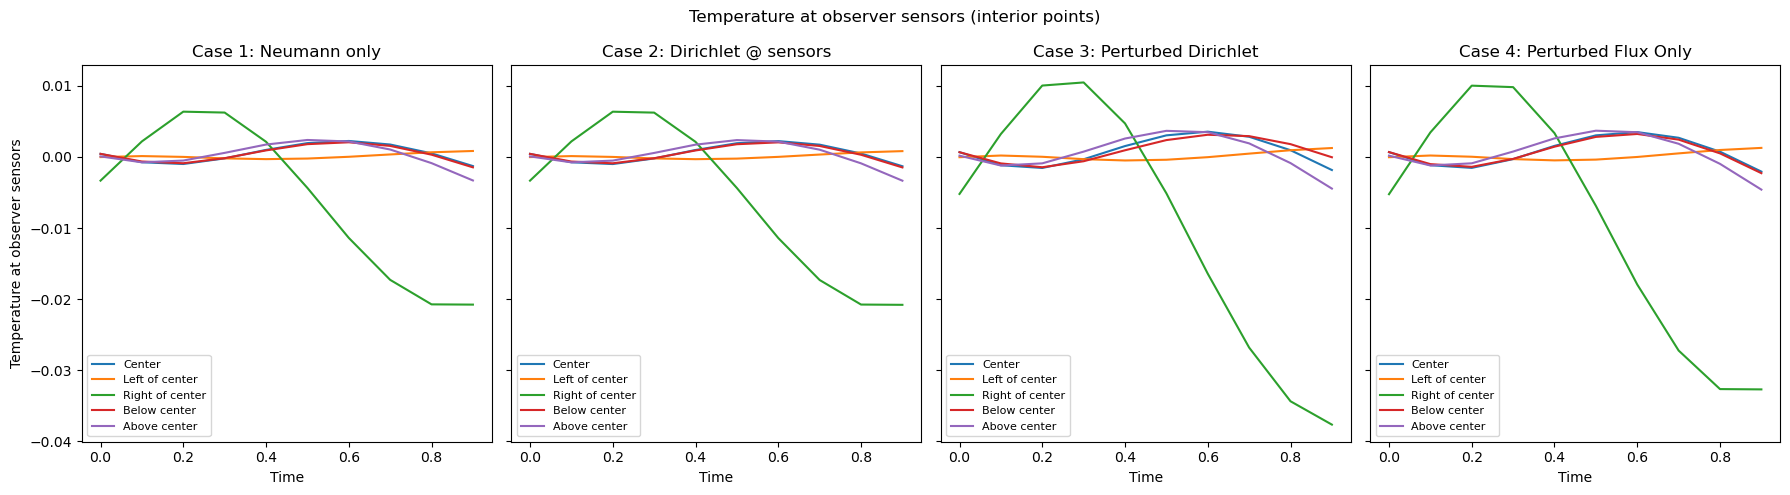

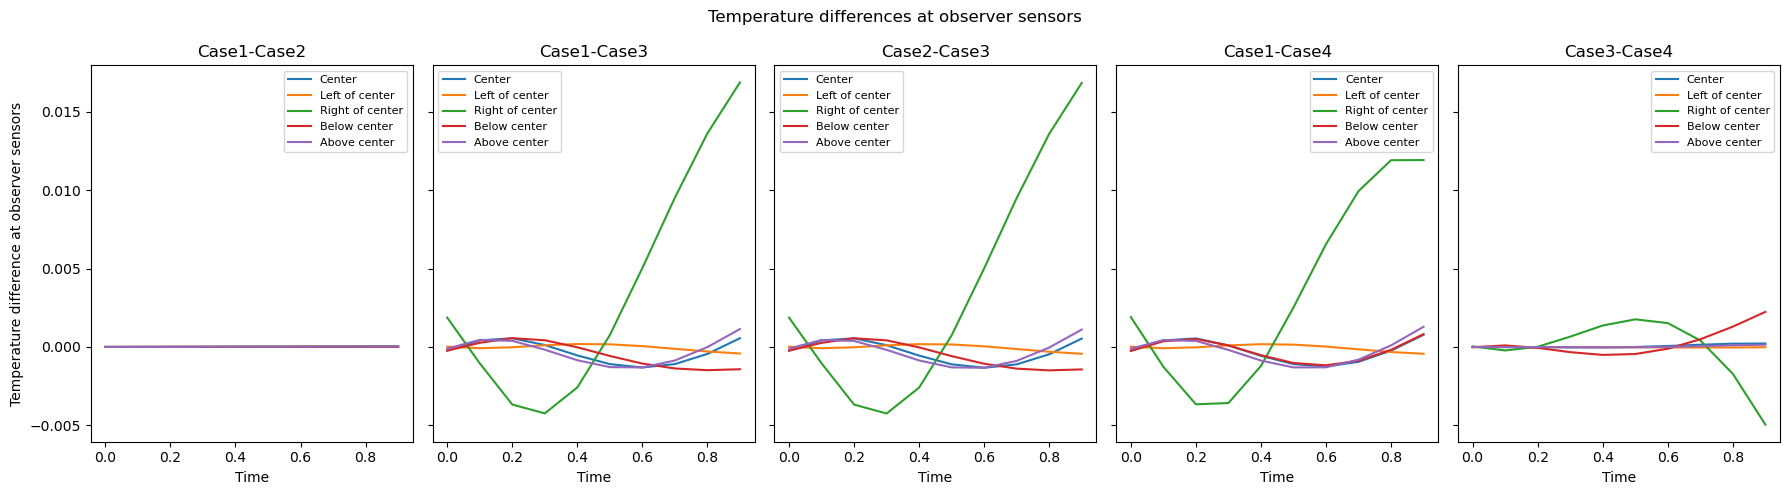

In [59]:
import matplotlib.pyplot as plt

# Helper: flatten observer arrays for plotting
def flatten_obs(obs_arr):
    # obs_arr: (num_steps, num_observers, 1)
    return np.squeeze(np.array(obs_arr), axis=2)

observer_labels = [
    "Center", "Left of center", "Right of center", "Below center", "Above center"
]

obs1 = flatten_obs(case1_obs)
obs2 = flatten_obs(case2_obs)
obs3 = flatten_obs(case3_obs)
obs4 = flatten_obs(case4_obs)
steps = np.arange(obs1.shape[0]) * dt

# Plot temperature at observer sensors for all cases (3 subplots)
fig, axs = plt.subplots(1, 4, figsize=(18, 5), sharey=True)
for i, (obs, title) in enumerate(zip([obs1, obs2, obs3, obs4], ["Case 1: Neumann only", "Case 2: Dirichlet @ sensors", "Case 3: Perturbed Dirichlet", "Case 4: Perturbed Flux Only"])):
    for j, label in enumerate(observer_labels):
        axs[i].plot(steps, obs[:, j], label=label)
    axs[i].set_title(title)
    axs[i].set_xlabel("Time")
    if i == 0:
        axs[i].set_ylabel("Temperature at observer sensors")
    axs[i].legend(fontsize=8)
plt.suptitle("Temperature at observer sensors (interior points)")
plt.tight_layout()
plt.show()

# Plot temperature differences at observer sensors (3 subplots)
fig, axs = plt.subplots(1, 5, figsize=(18, 5), sharey=True)
diffs = [
    (obs1 - obs2, "Case1-Case2"),
    (obs1 - obs3, "Case1-Case3"),
    (obs2 - obs3, "Case2-Case3"),
    (obs1 - obs4, "Case1-Case4"),
    (obs3 - obs4, "Case3-Case4")
]
for i, (diff, diff_title) in enumerate(diffs):
    for j, label in enumerate(observer_labels):
        axs[i].plot(steps, diff[:, j], label=label)
    axs[i].set_title(diff_title)
    axs[i].set_xlabel("Time")
    if i == 0:
        axs[i].set_ylabel("Temperature difference at observer sensors")
    axs[i].legend(fontsize=8)
plt.suptitle("Temperature differences at observer sensors")
plt.tight_layout()
plt.show()


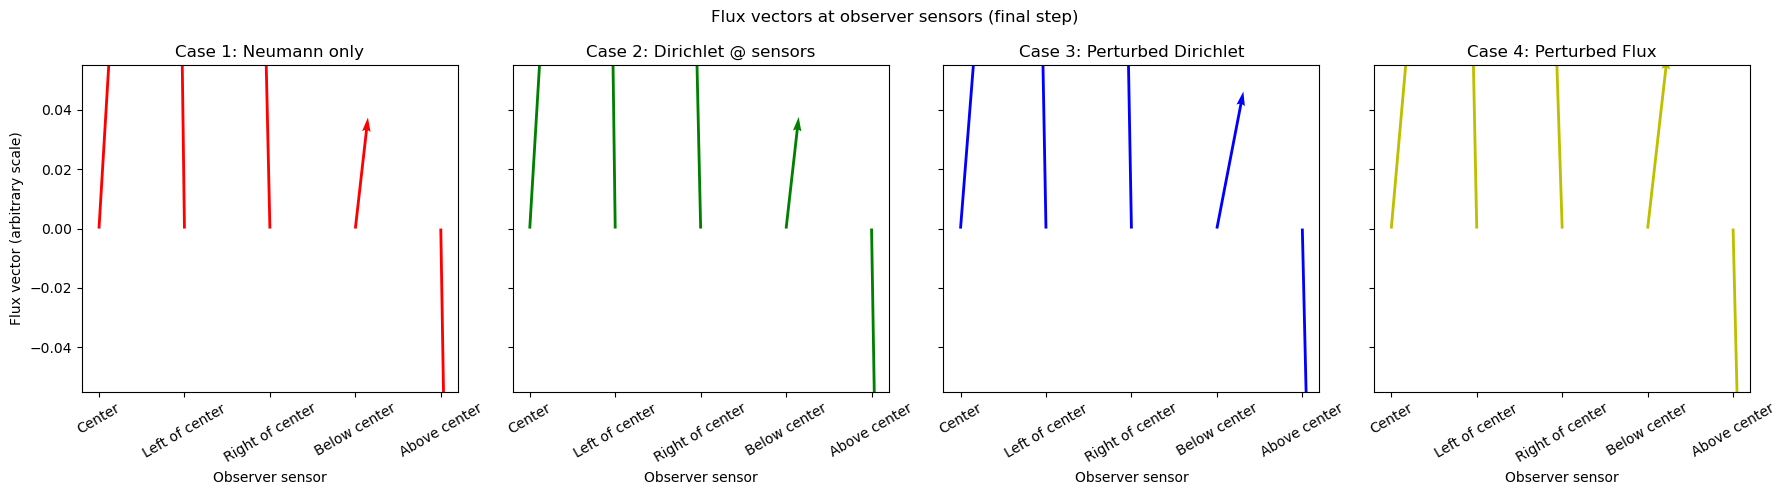

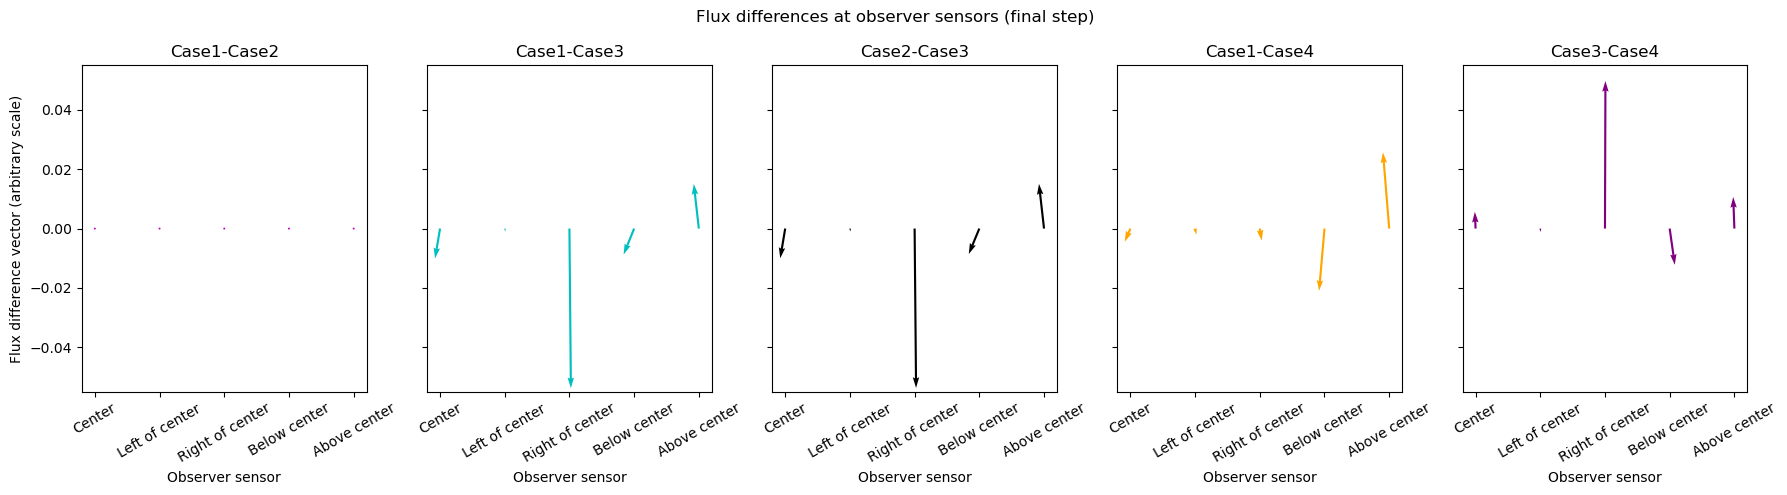

In [60]:

# Plot flux at observer sensors (final step, 3 subplots)
def eval_flux_at_points(flux, points):
    # flux: dolfinx function, points: (N, 3)
    domain = flux.function_space.mesh
    bb_tree = dolfinx.geometry.BoundingBoxTree(domain, domain.topology.dim)
    flux_vals = []
    for pt in points:
        cell_candidates = dolfinx.geometry.compute_collisions(bb_tree, [pt])
        colliding_cells = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates, [pt])
        cells = []
        if len(colliding_cells.links(0)) > 0:
            cells.append(colliding_cells.links(0)[0])
        val = flux.eval([pt], cells)
        # val shape: (1, 2) for 2D vector field, so take val[0]
        flux_vals.append(val)
    return np.array(flux_vals)  # shape: (num_points, 2)

flux_obs1 = eval_flux_at_points(flux1, observer_coords)
flux_obs2 = eval_flux_at_points(flux2, observer_coords)
flux_obs3 = eval_flux_at_points(flux3, observer_coords)
flux_obs4 = eval_flux_at_points(flux4, observer_coords)

# Ensure flux_obs arrays are 2D (num_observers, 2)
def ensure_flux_shape(arr):
    arr = np.asarray(arr)
    if arr.ndim == 1:
        # If shape is (2*N,), reshape to (N,2)
        if arr.size % 2 == 0 and arr.size > 2:
            arr = arr.reshape(-1, 2)
        else:
            arr = arr.reshape(1, -1)
    return arr

flux_obs1 = ensure_flux_shape(flux_obs1)
flux_obs2 = ensure_flux_shape(flux_obs2)
flux_obs3 = ensure_flux_shape(flux_obs3)
flux_obs4 = ensure_flux_shape(flux_obs4)

fig, axs = plt.subplots(1, 4, figsize=(18, 5), sharey=True)
for i, (flux_obs, title, color) in enumerate(zip([flux_obs1, flux_obs2, flux_obs3, flux_obs4], ["Case 1: Neumann only", "Case 2: Dirichlet @ sensors", "Case 3: Perturbed Dirichlet", "Case 4: Perturbed Flux"], ['r', 'g', 'b', 'y'])):
    for j, label in enumerate(observer_labels):
        axs[i].quiver(j, 0, flux_obs[j, 0], flux_obs[j, 1], angles='xy', scale_units='xy', scale=0.01, color=color)
    axs[i].set_xticks(range(len(observer_labels)))
    axs[i].set_xticklabels(observer_labels, rotation=30)
    axs[i].set_title(title)
    axs[i].set_xlabel("Observer sensor")
    if i == 0:
        axs[i].set_ylabel("Flux vector (arbitrary scale)")
plt.suptitle("Flux vectors at observer sensors (final step)")
plt.tight_layout()
plt.show()

# Plot flux differences at observer sensors (final step, 3 subplots)
fig, axs = plt.subplots(1, 5, figsize=(18, 5), sharey=True)
flux_diffs = [
    (flux_obs1 - flux_obs2, "Case1-Case2", 'm'),
    (flux_obs1 - flux_obs3, "Case1-Case3", 'c'),
    (flux_obs2 - flux_obs3, "Case2-Case3", 'k'),
    (flux_obs1 - flux_obs4, "Case1-Case4", 'orange'),
    (flux_obs3 - flux_obs4, "Case3-Case4", 'purple')
]
for i, (diff, diff_title, color) in enumerate(flux_diffs):
    diff = ensure_flux_shape(diff)
    for j, label in enumerate(observer_labels):
        axs[i].quiver(j, 0, diff[j, 0], diff[j, 1], angles='xy', scale_units='xy', scale=0.01, color=color)
    axs[i].set_xticks(range(len(observer_labels)))
    axs[i].set_xticklabels(observer_labels, rotation=30)
    axs[i].set_title(diff_title)
    axs[i].set_xlabel("Observer sensor")
    if i == 0:
        axs[i].set_ylabel("Flux difference vector (arbitrary scale)")
plt.suptitle("Flux differences at observer sensors (final step)")
plt.tight_layout()
plt.show()